In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_textbook.problems import grover_problem_oracle
from numpy import pi
from qiskit.circuit.library import Diagonal

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
def OracleCreator(nbits, solutions):
    elements = [1]*(2**nbits)
    
    for x in solutions:
        elements[x]=-1
    oraclegate = Diagonal(elements)
    gatename = " Oracle "
    
    for x in solutions:
        binnum = "{0:b}".format(x)
        gatename += binnum +" "
    oraclegate.name = gatename
    
    return oraclegate

In [3]:
def Diffuser(qc,var_qubits):
    nqubits = var_qubits.size
    
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)

    for qubit in range(nqubits-1):
        qc.barrier(qubit)

    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
        
    qc.barrier()

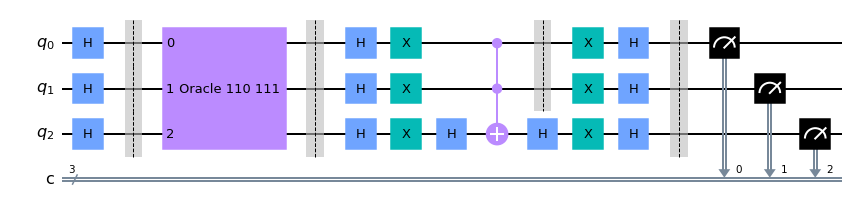

In [4]:
nbits = 3
solutions = [6,7]

qreg_q = QuantumRegister(nbits,'q')
creg_c = ClassicalRegister(nbits, 'c')
qc = QuantumCircuit(qreg_q, creg_c)

for i in range(nbits):
    qc.h(qreg_q[i])

qc.barrier()


loops = 1;
max_loops = (pi/4)*((2**nbits)**0.5)-0.5
oracle = OracleCreator(nbits,solutions)

while(loops<max_loops):
    qc.append(oracle,[0,1,2])
    qc.barrier()
    Diffuser(qc,qreg_q)
    loops+=1
    
qc.measure(qreg_q[0], creg_c[0])
qc.measure(qreg_q[1], creg_c[1])
qc.measure(qreg_q[2], creg_c[2])

qc.draw(fold=-1)


Total count  {'110': 525, '111': 499}


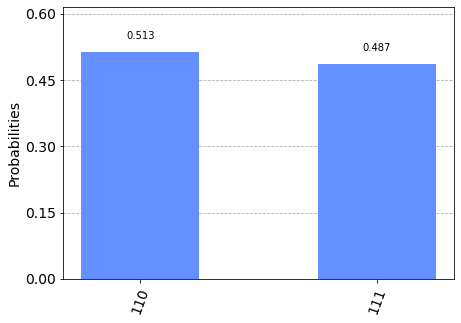

In [ ]:
platform = Aer.get_backend('qasm_simulator')
#platform = provider.get_backend('ibmq_lima')
job = execute(qc, platform, shots=1024)
result = job.result()
counts = result.get_counts(qc)
print("\nTotal count ",counts)
plot_histogram(result.get_counts())